In [27]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

Create a multiclass classficiation neural network. First, create a toy dataset from scikit learn.

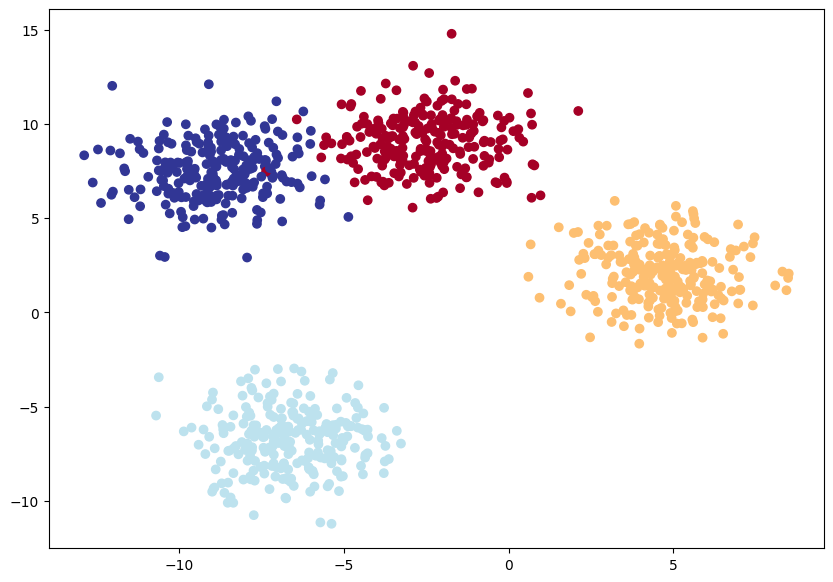

In [28]:
from sklearn.datasets import make_blobs

# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, 
                            n_features=NUM_FEATURES, 
                            centers=NUM_CLASSES, 
                            cluster_std=1.5, 
                            random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# Plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap = plt.cm.RdYlBu)


### Building a Multiclass classfication model

In [29]:
# Create device agnostics
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [30]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [31]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initialises multi-class classification model.
        
        Args: 
            input_features (int): Number of input features to the model
            output_features (int): Number of output classes
            hidden_units (int): Number of hidden units between layers, defaults to 8

        Returns:
        Examples:
        """
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x):
        return self.layer_stack(x)
    

model_0 = BlobModel(input_features=2, output_features=4, hidden_units=32).to(device)


In [32]:
# Specify a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

### Getting precition probabilities for a multi-class problem

In order to evaluate and train and test out model, we need to turn our logit outputs into prediction probabilites, then into their respective prediction classes.

In [33]:
model_0.eval()
with torch.inference_mode():
    y_pred_probs = torch.softmax(model_0(X_train.to(device)), dim = 1)
y_pred_probs[0,:], sum(y_pred_probs[0,:]), torch.argmax(y_pred_probs[0,:])

(tensor([0.1683, 0.1919, 0.2784, 0.3613], device='cuda:0'),
 tensor(1.0000, device='cuda:0'),
 tensor(3, device='cuda:0'))

In [34]:
# Create a training and testing loop for this model
epochs = 1000

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train)
    y_probs = torch.softmax(y_logits, dim = 1)
    y_preds = torch.argmax(y_logits, dim = 1)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # Calculate the loss
    loss = loss_fn(y_logits, y_train)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Evaluate the model
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test)
        test_loss = loss_fn(test_logits, y_test)
        test_probs = torch.softmax(test_logits, dim = 1)
        test_preds = torch.argmax(test_probs, dim = 1)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch%50 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Epoch: 0 | Loss: 1.4874, Acc: 3.00% | Test Loss: 0.8909, Test Acc: 56.50%
Epoch: 50 | Loss: 0.0391, Acc: 99.12% | Test Loss: 0.0312, Test Acc: 99.50%
Epoch: 100 | Loss: 0.0303, Acc: 99.12% | Test Loss: 0.0215, Test Acc: 99.50%
Epoch: 150 | Loss: 0.0277, Acc: 99.12% | Test Loss: 0.0184, Test Acc: 99.50%
Epoch: 200 | Loss: 0.0265, Acc: 99.25% | Test Loss: 0.0168, Test Acc: 99.50%
Epoch: 250 | Loss: 0.0258, Acc: 99.25% | Test Loss: 0.0158, Test Acc: 99.50%
Epoch: 300 | Loss: 0.0253, Acc: 99.25% | Test Loss: 0.0151, Test Acc: 99.50%
Epoch: 350 | Loss: 0.0249, Acc: 99.25% | Test Loss: 0.0146, Test Acc: 99.50%
Epoch: 400 | Loss: 0.0246, Acc: 99.25% | Test Loss: 0.0142, Test Acc: 99.50%
Epoch: 450 | Loss: 0.0243, Acc: 99.25% | Test Loss: 0.0138, Test Acc: 99.50%
Epoch: 500 | Loss: 0.0240, Acc: 99.25% | Test Loss: 0.0136, Test Acc: 99.50%
Epoch: 550 | Loss: 0.0238, Acc: 99.38% | Test Loss: 0.0133, Test Acc: 99.50%
Epoch: 600 | Loss: 0.0236, Acc: 99.38% | Test Loss: 0.0131, Test Acc: 99.50%
Epo

### Making and evaluating predictions with a PyTorch multi-class model

In [39]:
# Make predictions
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)

y_pred_probs = torch.softmax(y_logits,dim = 1)
y_pred_labels = torch.argmax(y_pred_probs, dim = 1)

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [40]:
# Import a function called `plot_decision_boundary()`
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print('helper_functions.py already exists. Skipping download.')
else:
    print("Download helper_functions.py")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open("helper_functions.py", 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists. Skipping download.


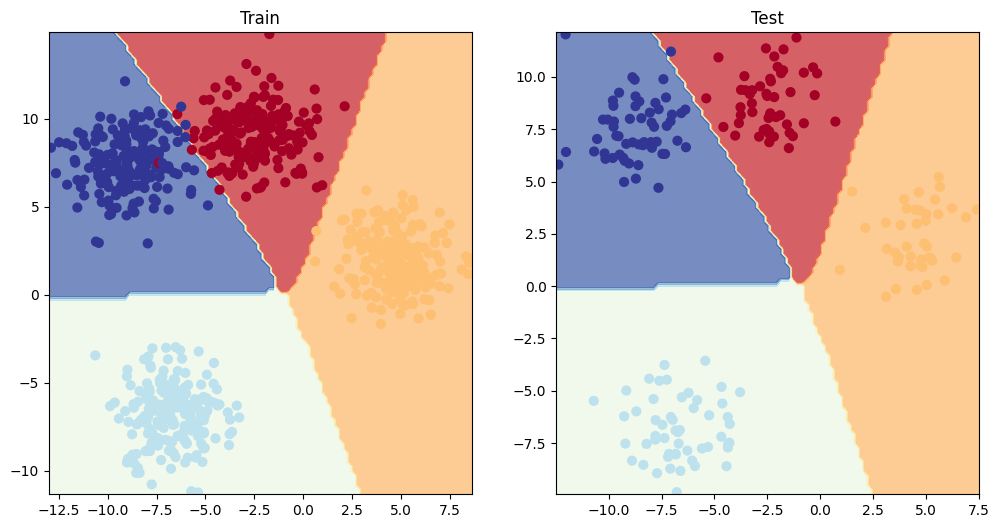

In [41]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

### A few more classfication metrics to evaluate our model

* Accuracy - out of 100 samples, how many does our model get right? (torchmetrics.Accuracy(), sklearn.metrics.accuracy_score())
* Precision (torchmetrics.Precision(), sklearn.metrics.precision_score())
* Recall (torchmetrics.Recall(), sklearn.metrics.recall_score())
* F1-score - combined precision and recall (torchmetrics.F1Score(), sklearn.metrics.f1_score())
* Confusion matrix (torchmetrics.ConfusionMatrix())
* Classification report - all the metrics (sklearn.metrics.classification_report())